# Learning Best Practices for Model Evalutaion and Hyperparameter Tuning

### Streamlining workflows with pipelines

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
       header=None)

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
#encode class labels (diagnosis)
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)

In [3]:
#malignant tumors now class 1, benign class 0
le.transform(['M', 'B'])

array([1, 0])

In [4]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)), ('clf', 
                                                LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


### stratified k-fold cross-validation

In [8]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)
scores = []
for k, (train,test) in enumerate(kfold):
    #use the returned indices in train to fit the logistic regression pipeline
    pipe_lr.fit(X_train[train], y_train[train])
    #use the test indices to calculate accuracy score of model
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist: [256 153], Acc: 0.891
Fold: 2, Class dist: [256 153], Acc: 0.978
Fold: 3, Class dist: [256 153], Acc: 0.978
Fold: 4, Class dist: [256 153], Acc: 0.913
Fold: 5, Class dist: [256 153], Acc: 0.935
Fold: 6, Class dist: [257 153], Acc: 0.978
Fold: 7, Class dist: [257 153], Acc: 0.933
Fold: 8, Class dist: [257 153], Acc: 0.956
Fold: 9, Class dist: [257 153], Acc: 0.978
Fold: 10, Class dist: [257 153], Acc: 0.956


In [9]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [10]:
#k-fold cross-validation scorer in scikit-learn
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [11]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


### Learning curves

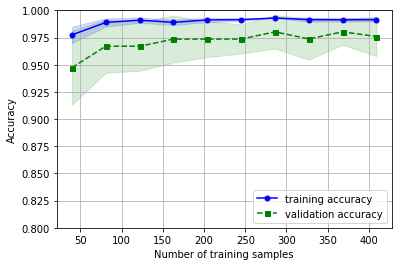

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                                       train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [15]:
#we can see our model performing well on the test dataset but maybe slightly overfitting the training data

### Validation curves

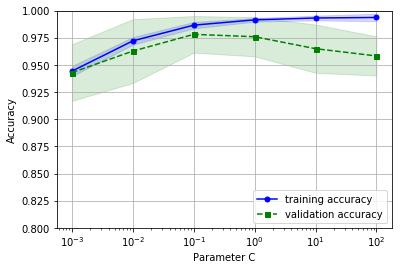

In [16]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
#specify parameter to evaluate as 'clf__C' to access logisticregression object inside pipeline
train_scores, test_scores = validation_curve(
                    estimator= pipe_lr, X=X_train, y=y_train, param_name='clf__C', param_range=param_range, cv=10)
train_mean= np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', marker='s', linestyle='--', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()


In [17]:
#sweet spot seems to be about C=0.1
#smaller values model slightly underfits, larger values model slightly overfits

### Tuning hyperparameters via grid search

In [19]:
#train and tune a SVM pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
#parameters we want to tune
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

0.978021978022


In [20]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [21]:
#use the independent test dataset to estimate performance of best selected model
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


### Nested cross-validation

In [22]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [24]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=[
        {'max_depth':[1,2,3,4,5,6,7,None]}], scoring='accuracy', cv=5)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=2)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.906 +/- 0.015


### Performance evaluation metrics

In [26]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


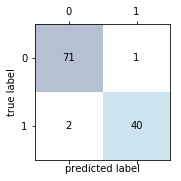

In [28]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [29]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976


In [30]:
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Recall: 0.952


In [31]:
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.964


In [32]:
#Remember positive class in scikit-learn is class labeled 1
#can specify different positive label using make_scorer function

from sklearn.metrics import make_scorer
scorer = make_scorer(f1_score, pos_label=0)
#use homemade scorer as scoring parameter in gridsearch
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)

### Receiver operator characteristic (ROC) graphs

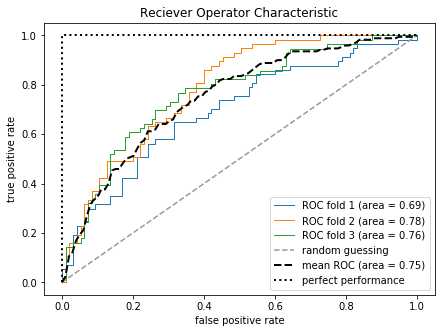

In [34]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)), ('clf', LogisticRegression(penalty='l2',
                                                                                    random_state=0, C=100.0))])
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    #interpolate avg ROC curve from three folds
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    #calculate area under the curve via auc function
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0,1], [0,1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0 , 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Reciever Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

In [35]:
#if just interested in ROC AUC score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4,14]])

print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))

ROC AUC: 0.662


In [36]:
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

Accuracy: 0.711


### scoring metrics for multiclass classification

In [37]:
#weighted macro-average is default for multiclass problems, but can specifiy averaging method

pre_scorer = make_scorer(score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')